In [1]:
from lusidtools.jupyter_tools import toggle_code

"""Dividends & withholding taxes in LUSID

Attributes
----------
corporate actions
tax rule sets
dividends
"""

toggle_code("Toggle Docstring")

_This notebook can be reviewed as as slideshow in Jupyter._

_To view as slides, select View > Cell Toolbar > Slideshow._

_Select the first cell in the notebook and click the 'Enter/Exit RISE Slideshow' button on the toolbar (it looks like a bar chart). Use the spacebar to progress through the slideshow._

## Table of Contents:

- 1. [Setup LUSID](#1.-setup-lusid)
- 2. [Create a Portfolio with associated Corporate Action Source](#2.-create-a-portfolio-with-associated-corporate-action-source)
- 3. [Creating our Equity Instruments](#3.-creating-our-equity-instruments)
  - 3.1. [Create the *CountryCode* property definition](#3.1.-create-the-*countrycode*-property-definition)
  - 3.2. [Create the equities](#3.2.-create-the-equities)
- 4. [Set our existing holdings](#4.-set-our-existing-holdings)
  - 4.1. [Set holdings as cash amounts](#4.1.-set-holdings-as-cash-amounts)
  - 4.2. [Add some Transactions to our portfolio](#4.2.-add-some-transactions-to-our-portfolio)
- 5. [Dividends](#5.-dividends)
- 6. [Taxing our dividends](#6.-taxing-our-dividends)
  - 6.1. [Creating a TaxRuleSet with different rates over time](#6.1.-creating-a-taxruleset-with-different-rates-over-time)
  - 6.2. [Dividends after tax](#6.2.-dividends-after-tax)
- 7. [Tax rules are evaluated in turn until a match is found](#7.-tax-rules-are-evaluated-in-turn-until-a-match-is-found)
  - 7.1. [Load our SBRY dividends](#7.1.-load-our-sbry-dividends)
  - 7.2. [Add new instrument property and populate on our SBRY equity](#7.2.-add-new-instrument-property-and-populate-on-our-sbry-equity)
  - 7.3. [Update our TaxRuleSet with an extra rule](#7.3.-update-our-taxruleset-with-an-extra-rule)
- 8. [Adding another TaxRuleSet](#8.-adding-another-taxruleset)
- 9. [Delete data this notebook has created](#9.-delete-data-this-notebook-has-created)

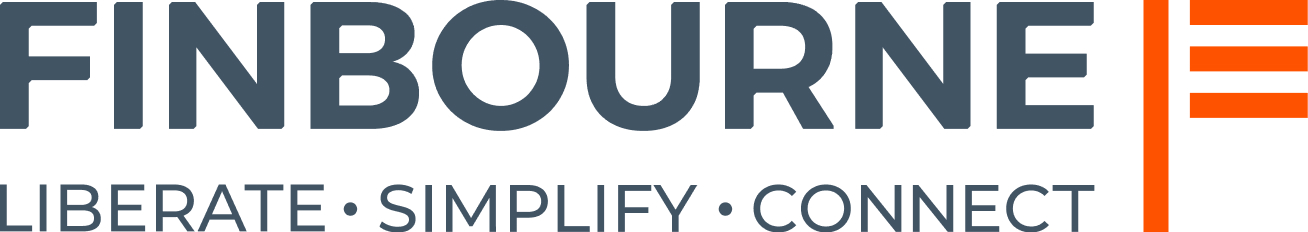

# Taxing dividends

This notebook demonstrates how dividends can be taxed using [`Tax Rule Sets`](https://www.lusid.com/docs/api/#tag/Tax-Rule-Sets) in LUSID.

In this notebook, we will create some equities and their corresponding dividends before applying different tax rates to those dividends based on a property of the equity.

We will then show how the tax rate to apply is determined using ordered tax rules.

Finally, we'll see an example that applies multiple taxes to the same dividend.

## 1. Setup LUSID

In [2]:
# Import generic non-LUSID packages
import os
import pandas as pd
import json
import pytz
import numpy as np

# Import key modules from the LUSID package
import lusid as lu
import lusid.models as lm
from lusid.utilities import ApiClientFactory
from datetime import datetime

# Import key functions from Lusid-Python-Tools and other packages
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from lusidjam import RefreshingToken

# Set the secrets path
secrets_path = os.getenv("FBN_SECRETS_PATH")

# For running the notebook locally
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

# Authenticate our user and create our API client
api_factory = ApiClientFactory(
    token=RefreshingToken(), api_secrets_filename=secrets_path
)

print("LUSID Environment Initialised")
print(
    "LUSID API Version :",
    api_factory.build(lu.api.ApplicationMetadataApi).get_lusid_versions().build_version,
)

LUSID Environment Initialised
LUSID API Version : 0.6.10975.0


In [3]:
# LUSID Variable Definitions
corporate_action_sources_api = api_factory.build(lu.api.CorporateActionSourcesApi)
transaction_portfolios_api = api_factory.build(lu.api.TransactionPortfoliosApi)
property_definitions_api = api_factory.build(lu.api.PropertyDefinitionsApi)
instruments_api = api_factory.build(lu.api.InstrumentsApi)
tax_rules_api = api_factory.build(lu.api.TaxRuleSetsApi)
portfolios_api = api_factory.build(lu.api.PortfoliosApi)

In [4]:
# Define scope and some other variables we'll use throughout the notebook
scope = "taxRuleSetSample"
ca_source_code = "taxRuleSetSampleCAS"
portfolio_code = "taxRuleSetSamplePortfolio"

withholding_output_property = "withholdingTax"
relief_output_property = "taxRelief"

tax_rule_set_withholding = "grossWithholdingTaxRuleSet"
tax_rule_set_relief = "reliefTaxRuleSet"

In [5]:
# Define the files containing data we'll be using in this notebook

# Transactions
txns = pd.read_csv("data/taxrs_transactions.csv")

# Dividend data
rr_dividends = pd.read_csv("data/taxrs_rr_dividends.csv")
sbry_dividends = pd.read_csv("data/taxrs_sbry_dividends.csv")
msft_dividends = pd.read_csv("data/taxrs_msft_dividends.csv")

## 2. Create a Portfolio with associated Corporate Action Source

We first create a [`Corporate Actions Source`](https://support.lusid.com/knowledgebase/article/KA-01867). This will be linked to the [`Transaction Portfolio`](https://support.lusid.com/knowledgebase/article/KA-01851/) that we will put our equities in.

In [6]:
try:

    source_request = lm.CreateCorporateActionSourceRequest(
        scope=scope,
        code=ca_source_code,
        display_name="CA Source - Tax Rules Sample",
        description="Corporate actions source for sample notebook",
        instrument_scopes=[f"{scope}"],
    )

    corporate_action_sources_api.create_corporate_action_source(
        create_corporate_action_source_request=source_request
    )
    print(f'CorporateActionSource "{scope}/{ca_source_code}" created')

except lu.ApiException as e:
    detail = json.loads(e.body)
    if detail["code"] == 173:
        print(f'CorporateActionSource "{scope}/{ca_source_code}" already exists')
    else:
        raise e

CorporateActionSource "taxRuleSetSample/taxRuleSetSampleCAS" already exists


Now we create our `Transaction Portfolio`.

In [7]:
try:
    transaction_portfolios_api.create_portfolio(
        scope=scope,
        create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
            display_name=portfolio_code,
            code=portfolio_code,
            base_currency="GBP",
            created=datetime(year=2010, month=1, day=1, tzinfo=pytz.UTC),
            corporate_action_source_id=lu.models.ResourceId(
                scope=scope, code=ca_source_code
            ),
            instrument_scopes=[f"{scope}"],
        ),
    )
    print(f'Portfolio "{scope}/{portfolio_code}" created')

except lu.ApiException as e:
    detail = json.loads(e.body)
    if detail["code"] == 112:
        print(f'Portfolio "{scope}/{portfolio_code}" already exists')
    else:
        raise e

Portfolio "taxRuleSetSample/taxRuleSetSamplePortfolio" already exists


## 3. Creating our Equity Instruments
We will add 3 equity instruments to LUSID: 2 UK equities and 1 USA equity.

On each we will set a *CountryCode* [property](https://support.lusid.com/knowledgebase/article/KA-01855/) that will be used to apply the correct tax rules for dividends.

### 3.1 Create the *CountryCode* property definition
First we create a [property definition](https://support.lusid.com/knowledgebase/article/KA-01856/en-us) for the *CountryCode* property.

In [8]:
try:
    property_definition_request = lm.CreatePropertyDefinitionRequest(
        domain="Instrument",
        scope=scope,
        code="CountryCode",
        display_name="Country Code",
        data_type_id=lm.ResourceId(
            scope="system",
            code="string",
        ),
        life_time="Perpetual",
    )

    property_definitions_api.create_property_definition(
        create_property_definition_request=property_definition_request
    )
    print(f'Property "{scope}/CountryCode" created')

except lu.ApiException as e:
    detail = json.loads(e.body)
    if detail["code"] == 124:
        print(f'Property "{scope}/CountryCode" already exists')
    else:
        raise e

Property "taxRuleSetSample/CountryCode" already exists


### 3.2 Create the equities

We then create a function to help upsert equities into LUSID.

In [9]:
def create_equity(
    name,
    client_internal,
    dom_ccy,
    country_code,
):

    lusid_instrument = lm.Equity(
        instrument_type="Equity",
        identifiers=lm.EquityAllOfIdentifiers(client_internal=client_internal),
        dom_ccy=dom_ccy,
    )

    model_property = lm.ModelProperty(
        key=f"Instrument/{scope}/CountryCode",
        value=lm.PropertyValue(label_value=country_code),
    )

    instrument_definition = lm.InstrumentDefinition(
        name=name,
        identifiers={"ClientInternal": lm.InstrumentIdValue(value=client_internal)},
        properties=[model_property],
        definition=lusid_instrument,
    )

    # upsert the instrument
    upsert_request = {client_internal: instrument_definition}
    upsert_response = instruments_api.upsert_instruments(
        scope=scope, request_body=upsert_request
    )
    equity_luid = upsert_response.values[client_internal].lusid_instrument_id
    print(equity_luid)

Now we load our 3 equities into LUSID.

In [11]:
create_equity(
    name = "Microsoft",
    client_internal = "MSFT",
    dom_ccy = "USD",
    country_code = "USA"
)

create_equity(
    name = "Sainsbury",
    client_internal = "SBRY",
    dom_ccy = "GBP",
    country_code = "UK"
)

create_equity(
    name = "Rolls Royce",
    client_internal = "RR",
    dom_ccy = "GBP",
    country_code = "UK"
)

LUID_00003DT4
LUID_00003DT5
LUID_00003DT6


## 4. Set our existing holdings

Our initial [`Holdings`](https://support.lusid.com/knowledgebase/article/KA-01882/en-us) will consist of some cash and equities.

### 4.1 Set holdings as cash amounts

Let's start by adding some cash amounts into our portfolio.

_We fund our portfolio with enough cash such that after we purchase our equities we're left with £100 and $100._

In [12]:
# A function to help us set our holdings to cash amounts
def add_cash_as_holding(cash_amounts):

    holding_request = []
    for ccy, amount in cash_amounts.items():
        holding_request.append(
            lm.AdjustHoldingRequest(
                instrument_identifiers={"Instrument/default/Currency": ccy},
                tax_lots=[lm.TargetTaxLotRequest(units=amount)],
            )
        )

    transaction_portfolios_api.set_holdings(
        scope=scope,
        code=portfolio_code,
        effective_at=datetime(year=2019, month=12, day=31, tzinfo=pytz.UTC),
        adjust_holding_request=holding_request,
    )


cash_amounts = {"GBP": 327900, "USD": 318100}

add_cash_as_holding(cash_amounts)

### 4.2 Add some Transactions to our portfolio

We now add some [`Transactions`](https://support.lusid.com/knowledgebase/article/KA-01868/en-us) to our portfolio to buy the equities.

In [13]:
display(txns)

,txn_id,trade_date,transaction_type,inst_client_internal,instrument_currency,quantity,price,net_money
0,tx_00001,2020-01-02T00:00:00.0000000+00:00,Buy,MSFT,USD,2000,159.00,318000
1,tx_00002,2020-01-02T00:00:00.0000000+00:00,Buy,SBRY,GBP,80000,2.32,185600
2,tx_00003,2020-01-02T00:00:00.0000000+00:00,Buy,RR,GBP,60000,2.37,142200


In [14]:
# Upsert transactions
transactions_request = []
txn_response = []
for row, txn in txns.iterrows():

    # build request body
    transactions_request.append(
        lm.TransactionRequest(
            transaction_id=txn["txn_id"],
            type=txn["transaction_type"],
            instrument_identifiers={
                "Instrument/default/ClientInternal": txn["inst_client_internal"]
            },
            transaction_date=txn["trade_date"],
            settlement_date=txn["trade_date"],
            units=txn["quantity"],
            transaction_price=lm.TransactionPrice(price=txn["price"], type="Price"),
            total_consideration=lm.CurrencyAndAmount(
                amount=txn["net_money"], currency=txn["instrument_currency"]
            ),
        )
    )

    # Make Upsert Transactions call to LUSID
    txn_response.append(
        transaction_portfolios_api.upsert_transactions(
            scope=scope, code=portfolio_code, transaction_request=transactions_request
        )
    )

print(f"{len(txn_response)} transactions upserted")

3 transactions upserted


In [15]:
def get_portfolio_holdings(y, m, d):
    
    holdings = transaction_portfolios_api.get_holdings(
        scope=scope,
        code=portfolio_code,
        effective_at=datetime(year=y, month=m, day=d, tzinfo=pytz.utc),
        property_keys=["Instrument/default/Name", f"Instrument/{scope}/CountryCode"],
    )

    df_holdings = lusid_response_to_data_frame(holdings)

    if 'transaction.transaction_id' not in df_holdings.columns:
        df_holdings['transaction.transaction_id'] = np.nan
    
    df_holdings = df_holdings[["properties.Instrument/default/Name.value.label_value",
        f"properties.Instrument/{scope}/CountryCode.value.label_value",
            "holding_type_name",
            "units",
            "transaction.transaction_id"
        ]]

    df_holdings.rename(columns={
        "properties.Instrument/default/Name.value.label_value": "Instrument",
        f"properties.Instrument/{scope}/CountryCode.value.label_value": "CountryCode",
        "holding_type_name": "HoldingType",
        "units": "Units",
        "transaction.transaction_id": "TransactionId"
    }, inplace = True)

    return df_holdings[["Instrument", "TransactionId", "CountryCode", "Units", "HoldingType"]]

In [16]:
def get_portfolio_holdings_centeraligned(y, m, d):
    return get_portfolio_holdings(y, m, d).style.set_properties(
        **{"text-align": "center"}
    )

In [17]:
display(get_portfolio_holdings_centeraligned(2020, 1, 2))

,Instrument,TransactionId,CountryCode,Units,HoldingType
0,GBP,nan,nan,100.000000,Balance
1,USD,nan,nan,100.000000,Balance
2,Microsoft,nan,USA,2000.000000,Position
3,Sainsbury,nan,UK,80000.000000,Position
4,Rolls Royce,nan,UK,60000.000000,Position


## 5. Dividends

We will now add some dividends for Rolls Royce to our [`Corporate Action Source`](https://support.lusid.com/knowledgebase/article/KA-01867/en-us).

_N.B. As well as the data required to add Rolls Royce dividends to our `Corporate Action Source` the CSV also includes columns that show our expected GBP cash amounts given the tax rates used in this notebook when only the RR dividends are in LUSID._

In [18]:
rr_dividends.style.set_properties(**{"text-align": "center"})

,code,client_internal,div_amount,div_ccy,announcement_date,ex_date,record_date,payment_date,Holding,Expected Gross Dividend (div_amount * Holding),Expected Tax Rate,Expected Tax Amount (Gross * Tax Rate),Expected Net Dividend (Gross - Tax),Expected cash prior to dividend,Expected cash after net dividend
0,RR_1_20200707,RR,0.037900,GBP,31-Mar-20,28-Apr-20,29-Apr-20,07-Jul-20,60000,2274,20%,454.800000,1819.200000,100.000000,1919.200000
1,RR_2_20210107,RR,0.035000,GBP,01-Oct-20,29-Oct-20,30-Oct-20,07-Jan-21,60000,2100,20%,420.000000,1680.000000,1919.200000,3599.200000
2,RR_3_20210707,RR,0.037500,GBP,31-Mar-21,28-Apr-21,29-Apr-21,07-Jul-21,60000,2250,22%,495.000000,1755.000000,3599.200000,5354.200000
3,RR_4_20220107,RR,0.040200,GBP,01-Oct-21,29-Oct-21,01-Nov-21,07-Jan-22,60000,2412,22%,530.640000,1881.360000,5354.200000,7235.560000
4,RR_5_20220807,RR,0.039900,GBP,31-Mar-22,28-Apr-22,29-Apr-22,07-Jul-22,60000,2394,24%,574.560000,1819.440000,7235.560000,9055.000000


In [20]:
def to_datetime(date):
    datetime_date = datetime.strptime(date, "%d-%b-%y").replace(tzinfo=pytz.utc)
    return datetime_date


def load_dividends(dividends):
    dividend_request = []

    for i, r in dividends.iterrows():
        dividend_request.append(
            lm.UpsertCorporateActionRequest(
                corporate_action_code=r["code"],
                announcement_date=to_datetime(r["announcement_date"]),
                ex_date=to_datetime(r["ex_date"]),
                record_date=to_datetime(r["record_date"]),
                payment_date=to_datetime(r["payment_date"]),
                transitions=[
                    lm.CorporateActionTransition(
                        input_transition=lm.CorporateActionTransitionComponentRequest(
                            instrument_identifiers={
                                "Instrument/default/ClientInternal": r[
                                    "client_internal"
                                ]
                            },
                            units_factor=1,
                            cost_factor=0,
                        ),
                        output_transitions=[
                            lm.CorporateActionTransitionComponentRequest(
                                instrument_identifiers={
                                    f"Instrument/default/Currency": r["div_ccy"]
                                },
                                units_factor=float(r["div_amount"]),
                                cost_factor=0,
                            )
                        ],
                    )
                ],
            )
        )

    corporate_action_sources_api.batch_upsert_corporate_actions(
        scope=scope,
        code=ca_source_code,
        upsert_corporate_action_request=dividend_request,
    )

    print(f"{len(dividend_request)} dividends created")

In [21]:
load_dividends(rr_dividends)

5 dividends created


## 6. Taxing our dividends

In this section we will add a TaxRuleSet applicable to our Rolls Royce dividends.

### 6.1 Creating a TaxRuleSet with different rates over time

We will create a TaxRuleSet targeting UK equity instruments with the following tax rates:

| Effective Date* | Tax Rate |
| -------------- | -------- |
| 01 Jan 2020 | 20% |
| 01 Jan 2021 | 22% |
| 01 Jan 2022 | 24% |

_*The dividend will be taxed at the rate in effect on the ex-date of that dividend._

_N.B. Although this example will only reference an instrument property (CountryCode), portfolio properties can be referenced as well!_

First we'll create our _output_property_key_. This is the property used to attach the calculated tax to the [`Output Transaction`](#https://support.lusid.com/knowledgebase/article/KA-01869/en-us).

In [22]:
try:
    property_definition_request = lm.CreatePropertyDefinitionRequest(
        domain="Transaction",
        scope=scope,
        code=withholding_output_property,
        display_name=withholding_output_property,
        data_type_id=lm.ResourceId(
            scope="system",
            code="number",
        ),
        life_time="Perpetual",
    )

    property_definitions_api.create_property_definition(
        create_property_definition_request=property_definition_request
    )
    print(f'Property "{scope}/{withholding_output_property}" created')

except lu.ApiException as e:
    detail = json.loads(e.body)
    if detail["code"] == 124:
        print(f'Property "{scope}/{withholding_output_property}" already exists')
    else:
        raise e

Property "taxRuleSetSample/withholdingTax" already exists


Now we'll add our TaxRuleSet.

First, we'll define helper functions to call either the Create or Update endpoints.

In [23]:
def tax_rules_set_exists(tax_rule_set_code):
    try:
        response = tax_rules_api.get_tax_rule_set(scope=scope, code=tax_rule_set_code)
        return True

    except lu.ApiException as e:
        detail = json.loads(e.body)
        if detail["code"] == 796:  # error code for 'Tax rule set not found'
            return False
        else:
            raise e


def upsert_tax_rule_set(tax_rule_set_code, effective_at, output_property, rules):

    display_name = output_property
    description = f"Tax Rule Set for {output_property}"
    output_property_key = f"Transaction/{scope}/{output_property}"

    if tax_rules_set_exists(tax_rule_set_code):
        # update existing

        tax_rule_set_request = lm.UpdateTaxRuleSetRequest(
            display_name=display_name,
            description=description,
            rules=rules,
        )

        tax_rules_api.update_tax_rule_set(
            scope=scope,
            code=tax_rule_set_code,
            update_tax_rule_set_request=tax_rule_set_request,
            effective_at=effective_at,
        )

        print(f"{tax_rule_set_code} updated")

    else:
        # create new

        tax_rule_set_request = lm.CreateTaxRuleSetRequest(
            id=lm.ResourceId(scope=scope, code=tax_rule_set_code),
            display_name=display_name,
            description=description,
            output_property_key=output_property_key,
            rules=rules,
        )

        tax_rules_api.create_tax_rule_set(
            create_tax_rule_set_request=tax_rule_set_request, effective_at=effective_at
        )

        print(f"{tax_rule_set_code} created")

The TaxRuleSet is now created and then updated with different rates for different effective_at dates.

In [24]:
def getRules(inst_property_name, inst_property_value, rate):
    return [
        lm.TaxRule(
            name=f"{inst_property_value}_TaxRule",
            description=f"{inst_property_value} TaxRule",
            rate=rate,
            match_criteria=[
                lm.PropertyValueEquals(
                    property_key=f"Instrument/{scope}/{inst_property_name}",
                    value=inst_property_value,
                    criterion_type="PropertyValueEquals",
                )
            ],
        )
    ]


rules = getRules("CountryCode", "UK", 0.20)
effective_at = datetime(year=2020, month=1, day=1, tzinfo=pytz.utc)
upsert_tax_rule_set(
    tax_rule_set_code = tax_rule_set_withholding,
    effective_at = effective_at,
    output_property = withholding_output_property,
    rules = rules
)

rules = getRules("CountryCode", "UK", 0.22)
effective_at = datetime(year=2021, month=1, day=1, tzinfo=pytz.utc)
upsert_tax_rule_set(
    tax_rule_set_code = tax_rule_set_withholding,
    effective_at = effective_at,
    output_property = withholding_output_property,
    rules = rules
)

rules = getRules("CountryCode", "UK", 0.24)
effective_at = datetime(year=2022, month=1, day=1, tzinfo=pytz.utc)
upsert_tax_rule_set(
    tax_rule_set_code = tax_rule_set_withholding,
    effective_at = effective_at,
    output_property = withholding_output_property,
    rules = rules
)

grossWithholdingTaxRuleSet updated
grossWithholdingTaxRuleSet updated
grossWithholdingTaxRuleSet updated


### 6.2 Dividends after tax

Let's remind ourselves of our first dividend.

In [25]:
div_cols_to_show = [
    "code",
    "div_amount",
    "ex_date",
    "payment_date",
    "Holding",
    "Expected Gross Dividend (div_amount * Holding)",
    "Expected Tax Rate",
    "Expected Tax Amount (Gross * Tax Rate)",
    "Expected Net Dividend (Gross - Tax)",
    "Expected cash prior to dividend",
    "Expected cash after net dividend",
]

In [26]:
rr_dividends.loc[0:0, div_cols_to_show].style.set_properties(**{"text-align": "center"})

,code,div_amount,ex_date,payment_date,Holding,Expected Gross Dividend (div_amount * Holding),Expected Tax Rate,Expected Tax Amount (Gross * Tax Rate),Expected Net Dividend (Gross - Tax),Expected cash prior to dividend,Expected cash after net dividend
0,RR_1_20200707,0.037900,28-Apr-20,07-Jul-20,60000,2274,20%,454.800000,1819.200000,100.000000,1919.200000


Examining our holdings between the first dividend ex-date and payment date we see the tax amount with [`holding type`](https://support.lusid.com/knowledgebase/article/KA-01880/) 'Receivable', as well as the gross dividend.

Unsettled dividends in holdings can be distinguished from each other using the transaction id, which comes from the corporate action's code.

In [27]:
get_portfolio_holdings_centeraligned(2020, 4, 29)

,Instrument,TransactionId,CountryCode,Units,HoldingType
0,GBP,nan,nan,100.000000,Balance
1,USD,nan,nan,100.000000,Balance
2,Microsoft,nan,USA,2000.000000,Position
3,Sainsbury,nan,UK,80000.000000,Position
4,Rolls Royce,nan,UK,60000.000000,Position
5,GBP,RR_1_20200707,nan,2274.000000,Accrual
6,GBP,RR_1_20200707,nan,-454.800000,Receivable


Examining our holdings after the first payment date we see our cash balance now reflects the net dividend amount.

In [28]:
get_portfolio_holdings_centeraligned(2020, 7, 8)

,Instrument,TransactionId,CountryCode,Units,HoldingType
0,GBP,nan,nan,1919.200000,Balance
1,USD,nan,nan,100.000000,Balance
2,Microsoft,nan,USA,2000.000000,Position
3,Sainsbury,nan,UK,80000.000000,Position
4,Rolls Royce,nan,UK,60000.000000,Position


By examining our holdings after each ex-date and payment date, we can see the gross dividend amounts and tax amounts calculated. Note how the tax rates used to determine our holdings change over time.

In [29]:
def get_holdings_over_time(holdingsDates):

    df_all = pd.DataFrame()

    for d in holdingsDates:
        df = get_portfolio_holdings(d.year, d.month, d.day)
        df["date"] = d.date()
        df_all = pd.concat([df, df_all], axis="rows")

    return df_all.pivot(
        index=["Instrument", "CountryCode", "HoldingType"],
        columns="date",
        values="Units",
    )

In [30]:
holdingsDates = [
    datetime(year=2020, month=4, day=29, tzinfo=pytz.UTC),
    datetime(year=2020, month=7, day=8, tzinfo=pytz.UTC),
    datetime(year=2020, month=10, day=30, tzinfo=pytz.UTC),
    datetime(year=2021, month=1, day=8, tzinfo=pytz.UTC),
    datetime(year=2021, month=4, day=29, tzinfo=pytz.UTC),
    datetime(year=2021, month=7, day=8, tzinfo=pytz.UTC),
    datetime(year=2021, month=10, day=30, tzinfo=pytz.UTC),
    datetime(year=2022, month=1, day=8, tzinfo=pytz.UTC),
    datetime(year=2022, month=4, day=29, tzinfo=pytz.UTC),
    datetime(year=2022, month=7, day=8, tzinfo=pytz.UTC),
]

In [31]:
display(get_holdings_over_time(holdingsDates))

date                                 2020-04-29  2020-07-08  2020-10-30  \
Instrument  CountryCode HoldingType                                       
GBP         NaN         Accrual          2274.0         NaN      2100.0   
                        Balance           100.0      1919.2      1919.2   
                        Receivable       -454.8         NaN      -420.0   
Microsoft   USA         Position         2000.0      2000.0      2000.0   
Rolls Royce UK          Position        60000.0     60000.0     60000.0   
Sainsbury   UK          Position        80000.0     80000.0     80000.0   
USD         NaN         Accrual             NaN         NaN         NaN   
                        Balance           100.0       100.0       100.0   

date                                 2021-01-08  2021-04-29  2021-07-08  \
Instrument  CountryCode HoldingType                                       
GBP         NaN         Accrual             NaN      2250.0         NaN   
                        Balance          3599.2      5346.4      7101.4   
                        Receivable          NaN      -495.0         NaN   
Microsoft   USA         Position         2000.0      2000.0      2000.0   
Rolls Royce UK          Position        60000.0     60000.0     60000.0   
Sainsbury   UK          Position        80000.0     80000.0     80000.0   
USD         NaN         Accrual             NaN         NaN         NaN   
                        Balance           100.0       100.0       100.0   

date                                 2021-10-30  2022-01-08  2022-04-29  \
Instrument  CountryCode HoldingType                                       
GBP         NaN         Accrual         2412.00         NaN     2394.00   
                        Balance         7101.40     8982.76    10702.76   
                        Receivable      -530.64         NaN     -574.56   
Microsoft   USA         Position        2000.00     2000.00     2000.00   
Rolls Royce UK          Position       60000.00    60000.00    60000.00   
Sainsbury   UK          Position       80000.00    80000.00    80000.00   
USD         NaN         Accrual             NaN         NaN     1200.00   
                        Balance          100.00      100.00      100.00   

date                                 2022-07-08  
Instrument  CountryCode HoldingType              
GBP         NaN         Accrual             NaN  
                        Balance         12522.2  
                        Receivable          NaN  
Microsoft   USA         Position         2000.0  
Rolls Royce UK          Position        60000.0  
Sainsbury   UK          Position        80000.0  
USD         NaN         Accrual             NaN  
                        Balance          1300.0

In [32]:
display(rr_dividends)

,code,client_internal,div_amount,div_ccy,announcement_date,ex_date,record_date,payment_date,Holding,Expected Gross Dividend (div_amount * Holding),Expected Tax Rate,Expected Tax Amount (Gross * Tax Rate),Expected Net Dividend (Gross - Tax),Expected cash prior to dividend,Expected cash after net dividend
0,RR_1_20200707,RR,0.0379,GBP,31-Mar-20,28-Apr-20,29-Apr-20,07-Jul-20,60000,2274,20%,454.80,1819.20,100.00,1919.20
1,RR_2_20210107,RR,0.0350,GBP,01-Oct-20,29-Oct-20,30-Oct-20,07-Jan-21,60000,2100,20%,420.00,1680.00,1919.20,3599.20
2,RR_3_20210707,RR,0.0375,GBP,31-Mar-21,28-Apr-21,29-Apr-21,07-Jul-21,60000,2250,22%,495.00,1755.00,3599.20,5354.20
3,RR_4_20220107,RR,0.0402,GBP,01-Oct-21,29-Oct-21,01-Nov-21,07-Jan-22,60000,2412,22%,530.64,1881.36,5354.20,7235.56
4,RR_5_20220807,RR,0.0399,GBP,31-Mar-22,28-Apr-22,29-Apr-22,07-Jul-22,60000,2394,24%,574.56,1819.44,7235.56,9055.00


We now add a single MSFT dividend with ex-date and payment date the same as our final RR dividend.

In [33]:
msft_dividends.style.set_properties(**{"text-align": "center"})

,code,client_internal,div_amount,div_ccy,announcement_date,ex_date,record_date,payment_date,Holding,Gross Dividend,Tax Rate,Expected: Tax Amount (Gross * Tax Rate),Expected: Gross - Tax,Starting cash,Expected: Holdings cash after net dividend
0,MSFT_1_20220807,MSFT,0.600000,USD,31-Mar-22,28-Apr-22,29-Apr-22,07-Jul-22,2000,1200,0%,0,1200,100,1300


In [34]:
load_dividends(msft_dividends)

1 dividends created


Our holdings reflect the gross MSFT dividend but it is not taxed because its _CountryCode_ (USA) does not fall within our TaxRuleSet's rules.

In [35]:
get_portfolio_holdings_centeraligned(2022, 4, 29)

,Instrument,TransactionId,CountryCode,Units,HoldingType
0,GBP,nan,nan,10702.760000,Balance
1,USD,nan,nan,100.000000,Balance
2,Microsoft,nan,USA,2000.000000,Position
3,Sainsbury,nan,UK,80000.000000,Position
4,Rolls Royce,nan,UK,60000.000000,Position
5,GBP,RR_5_20220807,nan,2394.000000,Accrual
6,GBP,RR_5_20220807,nan,-574.560000,Receivable
7,USD,MSFT_1_20220807,nan,1200.000000,Accrual


## 7. Tax rules are evaluated in turn until a match is found

We will now add some dividends for our Sainsbury (SBRY) instrument.

We will also add a new instrument [property](https://support.lusid.com/knowledgebase/article/KA-01855/) called _TaxClassification_. This will be set for SBRY, but not RR, such that SBRY will be caught by a new rule that we'll introduce before our existing (_CountryCode_=UK) rule in our TaxRuleSet.

### 7.1 Load our SBRY dividends

In [36]:
sbry_dividends.style.set_properties(**{"text-align": "center"})

,code,client_internal,div_amount,div_ccy,announcement_date,ex_date,record_date,payment_date,Holding,Expected Gross Dividend (div_amount * Holding),Expected Tax Rate,Expected Tax Amount (Gross * Tax Rate),Expected Net Dividend (Gross - Tax)
0,SBRY_1_20210315,SBRY,0.028000,GBP,18-Jan-21,15-Feb-21,16-Feb-21,15-Mar-21,80000,2240,22%,492.800000,1747.200000
1,SBRY_2_20220315,SBRY,0.025000,GBP,18-Jan-22,15-Feb-22,16-Feb-22,15-Mar-22,80000,2000,30%,600.000000,1400.000000


In [37]:
load_dividends(sbry_dividends)

2 dividends created


### 7.2 Add new instrument property and populate on our SBRY equity

Create the property.

In [38]:
try:
    property_definition_request = lm.CreatePropertyDefinitionRequest(
        domain="Instrument",
        scope=scope,
        code="TaxCategory",
        display_name="Tax Category",
        data_type_id=lm.ResourceId(
            scope="system",
            code="string",
        ),
        life_time="Perpetual",
    )

    property_definitions_api.create_property_definition(
        create_property_definition_request=property_definition_request
    )
    print(f'Property "{scope}/TaxCategory" created')

except lu.ApiException as e:
    detail = json.loads(e.body)
    if detail["code"] == 124:
        print(f'Property "{scope}/TaxCategory" already exists')
    else:
        raise e

Property "taxRuleSetSample/TaxCategory" already exists


Populate the property on the SBRY instrument.

In [39]:
try:
    model_property = lm.ModelProperty(
        key=f"Instrument/{scope}/TaxCategory",
        value=lm.PropertyValue(label_value="ABC123"),
    )

    upsert_instrument_property_request = lm.UpsertInstrumentPropertyRequest(
        identifier_type="ClientInternal", identifier="SBRY", properties=[model_property]
    )

    instruments_api.upsert_instruments_properties(
        upsert_instrument_property_request=[upsert_instrument_property_request],
        scope=scope,
    )

    print(f'Property "{scope}/TaxCategory" set on SBRY')

except lu.ApiException as e:
    raise e

Property "taxRuleSetSample/TaxCategory" set on SBRY


### 7.3 Update our TaxRuleSet with an extra rule

Our TaxRuleSet currently taxes dividends for instruments whose _CountryCode_=UK.

We will now add a rule **before** our existing rule, effective 01 Jan 2022, that will apply to instruments whose _TaxCategory_=ABC123. The tax rate will be 30%.

In [40]:
rules = [
    lm.TaxRule(
        name="category_TaxRule",
        description="Category TaxRule",
        rate=0.30,
        match_criteria=[
            lm.PropertyValueEquals(
                property_key=f"Instrument/{scope}/TaxCategory",
                value="ABC123",
                criterion_type="PropertyValueEquals",
            )
        ],
    ),
    lm.TaxRule(
        name="UK_TaxRule",
        description="UK TaxRule",
        rate=0.24,
        match_criteria=[
            lm.PropertyValueEquals(
                property_key=f"Instrument/{scope}/CountryCode",
                value="UK",
                criterion_type="PropertyValueEquals",
            )
        ],
    ),
]

effective_at = datetime(year=2022, month=1, day=1, tzinfo=pytz.utc)

upsert_tax_rule_set(
    tax_rule_set_code = tax_rule_set_withholding,
    effective_at = effective_at,
    output_property = withholding_output_property,
    rules = rules
)

grossWithholdingTaxRuleSet updated


Examining our holdings after the first SBRY ex-date in 2021 we can see our SBRY dividend has been correctly taxed at 22% as per the rule in effect throughout 2021.

In [41]:
div_cols_to_show = [
    "code",
    "div_amount",
    "ex_date",
    "payment_date",
    "Holding",
    "Expected Gross Dividend (div_amount * Holding)",
    "Expected Tax Rate",
    "Expected Tax Amount (Gross * Tax Rate)",
]

In [42]:
sbry_dividends.loc[0:0, div_cols_to_show].style.set_properties(
    **{"text-align": "center"}
)

,code,div_amount,ex_date,payment_date,Holding,Expected Gross Dividend (div_amount * Holding),Expected Tax Rate,Expected Tax Amount (Gross * Tax Rate)
0,SBRY_1_20210315,0.028000,15-Feb-21,15-Mar-21,80000,2240,22%,492.800000


In [43]:
get_portfolio_holdings_centeraligned(2021, 2, 16)

,Instrument,TransactionId,CountryCode,Units,HoldingType
0,GBP,nan,nan,3599.200000,Balance
1,USD,nan,nan,100.000000,Balance
2,Microsoft,nan,USA,2000.000000,Position
3,Sainsbury,nan,UK,80000.000000,Position
4,Rolls Royce,nan,UK,60000.000000,Position
5,GBP,SBRY_1_20210315,nan,2240.000000,Accrual
6,GBP,SBRY_1_20210315,nan,-492.800000,Receivable


If we also examine our holdings shortly after the second SBRY dividend ex-date, in 2022, we can see that our dividend has been taxed at 30% as it met the first of the 2 rules applicable in 2022.

In [44]:
sbry_dividends.loc[1:1, div_cols_to_show].style.set_properties(
    **{"text-align": "center"}
)

,code,div_amount,ex_date,payment_date,Holding,Expected Gross Dividend (div_amount * Holding),Expected Tax Rate,Expected Tax Amount (Gross * Tax Rate)
1,SBRY_2_20220315,0.025000,15-Feb-22,15-Mar-22,80000,2000,30%,600.000000


In [45]:
get_portfolio_holdings_centeraligned(2022, 2, 16)

,Instrument,TransactionId,CountryCode,Units,HoldingType
0,GBP,nan,nan,8982.760000,Balance
1,USD,nan,nan,100.000000,Balance
2,Microsoft,nan,USA,2000.000000,Position
3,Sainsbury,nan,UK,80000.000000,Position
4,Rolls Royce,nan,UK,60000.000000,Position
5,GBP,SBRY_2_20220315,nan,2000.000000,Accrual
6,GBP,SBRY_2_20220315,nan,-600.000000,Receivable
7,GBP,SBRY_2_20220315,nan,200.000000,Receivable


Also in 2022 our final RR dividend is taxed at 24% as it is not caught by the first rule, but is caught by the second rule.

In [46]:
rr_dividends.loc[4:4, div_cols_to_show].style.set_properties(**{"text-align": "center"})

,code,div_amount,ex_date,payment_date,Holding,Expected Gross Dividend (div_amount * Holding),Expected Tax Rate,Expected Tax Amount (Gross * Tax Rate)
4,RR_5_20220807,0.039900,28-Apr-22,07-Jul-22,60000,2394,24%,574.560000


In [47]:
get_portfolio_holdings_centeraligned(2022, 4, 29)

,Instrument,TransactionId,CountryCode,Units,HoldingType
0,GBP,nan,nan,10582.760000,Balance
1,USD,nan,nan,100.000000,Balance
2,Microsoft,nan,USA,2000.000000,Position
3,Sainsbury,nan,UK,80000.000000,Position
4,Rolls Royce,nan,UK,60000.000000,Position
5,GBP,RR_5_20220807,nan,2394.000000,Accrual
6,GBP,RR_5_20220807,nan,-574.560000,Receivable
7,USD,MSFT_1_20220807,nan,1200.000000,Accrual


## 8. Adding another TaxRuleSet

So far we have used a single TaxRuleSet to populate a single _output_property_key_. We will now add a second TaxRuleSet to simultaneously populate a second _output_property_key_ for the SBRY dividends.

This may be useful in cases where you want to apply multiple taxes to a single dividend.

This TaxRuleSet will be applicable from 01 Jan 2022 and the rate will be -10%.

As the rate is negative the cashflow produced will be a positive cash inflow to the portfolio. This may be useful to represent use cases such as tax relief.

First create the property.

In [48]:
try:
    property_definition_request = lm.CreatePropertyDefinitionRequest(
        domain="Transaction",
        scope=scope,
        code=relief_output_property,
        display_name="Tax Relief",
        data_type_id=lm.ResourceId(
            scope="system",
            code="number",
        ),
        life_time="Perpetual",
    )

    property_definitions_api.create_property_definition(
        create_property_definition_request=property_definition_request
    )
    print(f'Property "{scope}/{relief_output_property}" created')

except lu.ApiException as e:
    detail = json.loads(e.body)
    if detail["code"] == 124:
        print(f'Property "{scope}/{relief_output_property}" already exists')
    else:
        raise e

Property "taxRuleSetSample/taxRelief" already exists


Now create the TaxRuleSet to populate that property.

In [49]:
rules = getRules("TaxCategory", "ABC123", -0.1)
effective_at = datetime(year=2022, month=1, day=1, tzinfo=pytz.UTC)

upsert_tax_rule_set(
    tax_rule_set_code = tax_rule_set_relief,
    effective_at = effective_at,
    output_property = relief_output_property,
    rules = rules
)

reliefTaxRuleSet updated


If we now inspect our final SBRY dividend after its ex-date we can see the 10% tax relief as well - a second holding of type `Receivable`.

In [50]:
sbry_dividends.loc[1:1, div_cols_to_show].style.set_properties(
    **{"text-align": "center"}
)

,code,div_amount,ex_date,payment_date,Holding,Expected Gross Dividend (div_amount * Holding),Expected Tax Rate,Expected Tax Amount (Gross * Tax Rate)
1,SBRY_2_20220315,0.025000,15-Feb-22,15-Mar-22,80000,2000,30%,600.000000


In [51]:
get_portfolio_holdings_centeraligned(2022, 2, 16)

,Instrument,TransactionId,CountryCode,Units,HoldingType
0,GBP,nan,nan,8982.760000,Balance
1,USD,nan,nan,100.000000,Balance
2,Microsoft,nan,USA,2000.000000,Position
3,Sainsbury,nan,UK,80000.000000,Position
4,Rolls Royce,nan,UK,60000.000000,Position
5,GBP,SBRY_2_20220315,nan,2000.000000,Accrual
6,GBP,SBRY_2_20220315,nan,-600.000000,Receivable
7,GBP,SBRY_2_20220315,nan,200.000000,Receivable


This second TaxRuleSet did not affect our RR dividends as we can see by examining the holdings after the ex-date of the final RR dividend.

There is only one holding of type `Receivable` - from the TaxRuleSet we created earlier (grossWithholdingTaxRuleSet) - not from the tax relief rule set (reliefTaxRuleSet).

In [52]:
rr_dividends.loc[4:4, div_cols_to_show].style.set_properties(**{"text-align": "center"})

,code,div_amount,ex_date,payment_date,Holding,Expected Gross Dividend (div_amount * Holding),Expected Tax Rate,Expected Tax Amount (Gross * Tax Rate)
4,RR_5_20220807,0.039900,28-Apr-22,07-Jul-22,60000,2394,24%,574.560000


In [53]:
get_portfolio_holdings_centeraligned(2022, 4, 29)

,Instrument,TransactionId,CountryCode,Units,HoldingType
0,GBP,nan,nan,10582.760000,Balance
1,USD,nan,nan,100.000000,Balance
2,Microsoft,nan,USA,2000.000000,Position
3,Sainsbury,nan,UK,80000.000000,Position
4,Rolls Royce,nan,UK,60000.000000,Position
5,GBP,RR_5_20220807,nan,2394.000000,Accrual
6,GBP,RR_5_20220807,nan,-574.560000,Receivable
7,USD,MSFT_1_20220807,nan,1200.000000,Accrual


## 9. Delete data this notebook has created

So that this notebook can be run again we now delete some of the data it created.

We will delete:

- TaxRuleSet
- Portfolio
- CorporateActionSource
- PropertyDefinition

In [54]:
# Function to delete TaxRuleSets
def delete_tax_rule_set(rule_set_code_to_delete):
    try:
        tax_rules_api.delete_tax_rule_set(scope=scope, code=rule_set_code_to_delete)
        print(f'TaxRuleSet "{scope}/{rule_set_code_to_delete}" deleted')

    except lu.ApiException as e:
        detail = json.loads(e.body)
        if detail["code"] == 796:
            print(f'TaxRuleSet "{scope}/{rule_set_code_to_delete}" did not exist')
        else:
            raise e

In [55]:
# Function to delete Portfolios
def delete_portfolio(portfolio_to_delete):
    try:
        portfolios_api.delete_portfolio(scope=scope, code=portfolio_to_delete)
        print(f'Portfolio "{scope}/{portfolio_to_delete}" deleted')

    except lu.ApiException as e:
        detail = json.loads(e.body)
        if detail["code"] == 109:
            print(f'Portfolio "{scope}/{portfolio_to_delete}" did not exist')
        else:
            raise e

In [56]:
# Function to delete CorporateActionSource
def delete_corporate_action_source(cas_to_delete):
    try:
        corporate_action_sources_api.delete_corporate_action_source(
            scope=scope, code=cas_to_delete
        )
        print(f'CorporateActionSource "{scope}/{cas_to_delete}" deleted')

    except lu.ApiException as e:
        detail = json.loads(e.body)
        if detail["code"] == 391:
            print(f'CorporateActionSource "{scope}/{cas_to_delete}" did not exist')
        else:
            raise e

In [57]:
# Function to delete PropertyDefinition
def delete_property(domain, scope, code):
    try:
        property_definitions_api.delete_property_definition(
            domain=domain, scope=scope, code=code
        )
        print(f'{domain} property "{scope}/{code}" deleted')

    except lu.ApiException as e:
        detail = json.loads(e.body)
        if detail["code"] == 121:
            print(f'{domain} property "{scope}/{code}" did not exist')
        else:
            raise e

In [58]:
def delete_property(domain, scope, code):
    try:
        property_definitions_api.delete_property_definition(
            domain=domain, scope=scope, code=code
        )
        print(f'{domain} property "{scope}/{code}" deleted')

    except lu.ApiException as e:
        detail = json.loads(e.body)
        if detail["code"] == 121:
            print(f'{domain} property "{scope}/{code}" did not exist')
        else:
            raise e

In [59]:
delete_tax_rule_set(rule_set_code_to_delete = tax_rule_set_withholding)
delete_tax_rule_set(rule_set_code_to_delete = tax_rule_set_relief)

delete_portfolio(portfolio_to_delete = portfolio_code)

delete_corporate_action_source(cas_to_delete = ca_source_code)

delete_property(domain = "Instrument", scope = scope, code = "CountryCode")
delete_property(domain = "Instrument", scope = scope, code = "TaxCategory")
delete_property(domain = "Transaction", scope = scope, code = withholding_output_property)
delete_property(domain = "Transaction", scope = scope, code = relief_output_property)

TaxRuleSet "taxRuleSetSample/grossWithholdingTaxRuleSet" deleted
TaxRuleSet "taxRuleSetSample/reliefTaxRuleSet" deleted
Portfolio "taxRuleSetSample/taxRuleSetSamplePortfolio" deleted
CorporateActionSource "taxRuleSetSample/taxRuleSetSampleCAS" deleted
Instrument property "taxRuleSetSample/CountryCode" deleted
Instrument property "taxRuleSetSample/TaxCategory" deleted
Transaction property "taxRuleSetSample/withholdingTax" deleted
Transaction property "taxRuleSetSample/taxRelief" deleted


# End